In [31]:
from sdv.single_table import TVAESynthesizer
from sdv.metadata import SingleTableMetadata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance, ks_2samp
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE

In [32]:
df = pd.read_csv("augmented_dataset.csv")

# df = df.drop(columns=['BMI', 'BSA', 'IMT MAX', 'LVMi', 'EF', 'Record'])

# df['Gender'] = df['Gender'].str.upper().map({'M': 0, 'F': 1})
# df['Smoker'] = df['Smoker'].str.upper().map({'NO': 0, 'YES': 1})
df.head()

,Age,Weight,Height,SBP,DBP,Smoker,Gender,Vascular event
0,56,104.963004,177.892854,139.417249,85.303739,1,0,none
1,80,79.218044,164.826315,175.238742,73.442780,0,1,none
2,77,89.155377,178.397928,138.890499,89.451412,0,0,none
3,66,80.156848,172.108310,102.858142,62.881078,0,1,none
4,84,72.357701,167.408929,124.863981,68.530730,0,0,none


In [33]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

In [34]:
model = TVAESynthesizer(metadata=metadata, epochs=500)

/home/elukbog/.local/lib/python3.10/site-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/home/elukbog/.local/lib/python3.10/site-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [35]:
model.fit(df)

synthetic_crfs = model.sample(1000)
synthetic_crfs.to_csv("synthetic_crfs.csv", index=False)

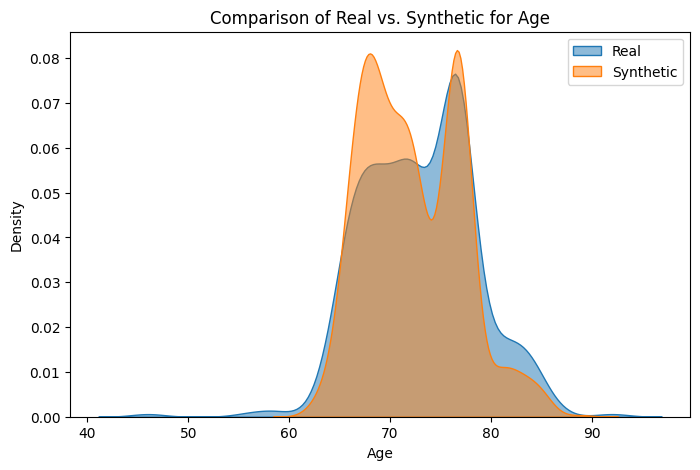

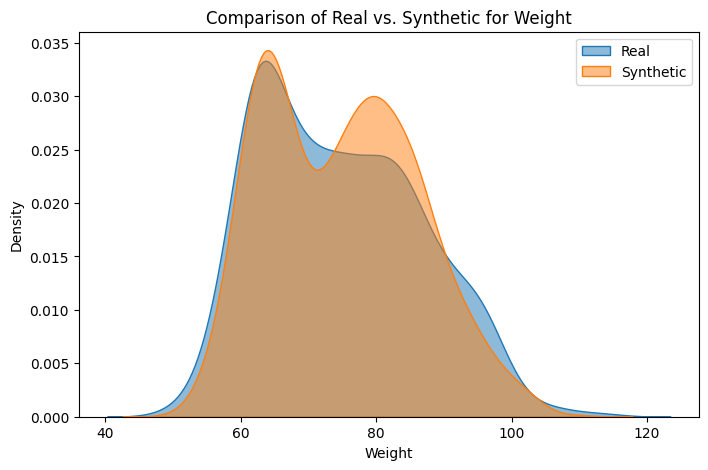

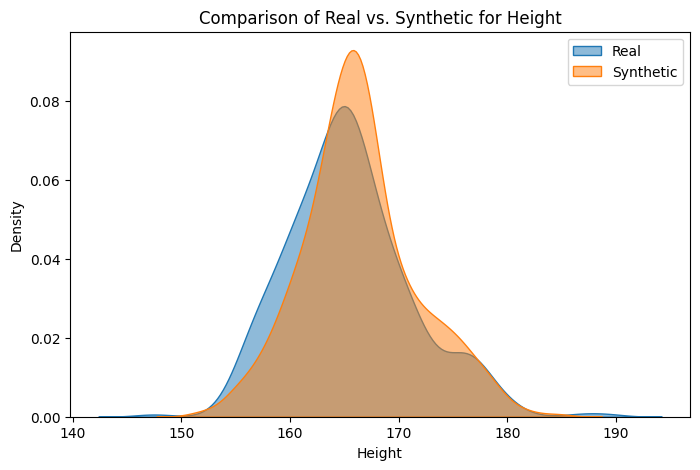

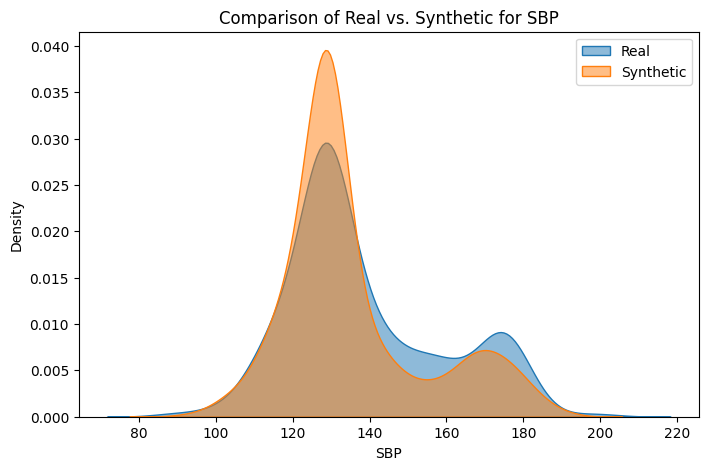

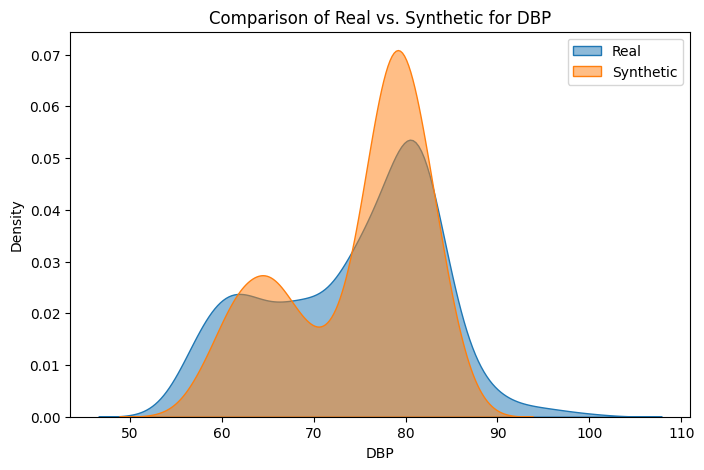

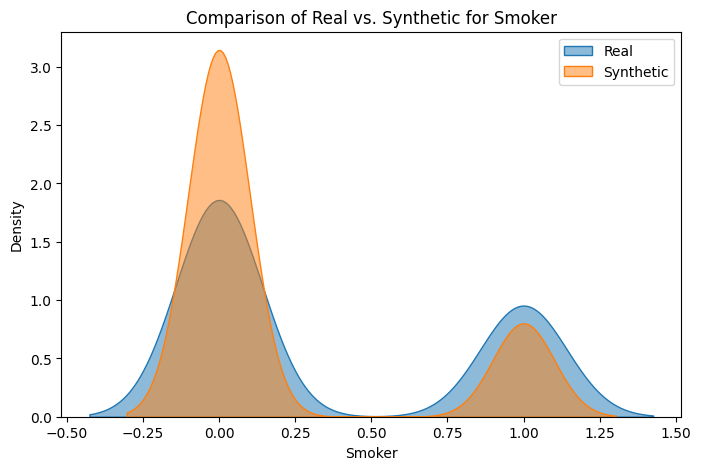

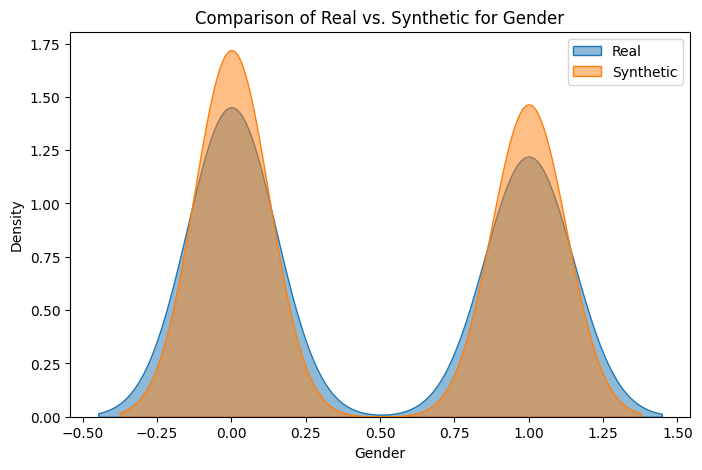

In [36]:
def distrib_comp():
    for column in df.columns:
        if column != "Vascular event":
            plt.figure(figsize=(8, 5))
            sns.kdeplot(df[column], label="Real", fill=True, alpha=0.5)
            sns.kdeplot(synthetic_crfs[column],
                        label="Synthetic", fill=True, alpha=0.5)
            plt.title(f"Comparison of Real vs. Synthetic for {column}")
            plt.legend()
            plt.show()

distrib_comp()

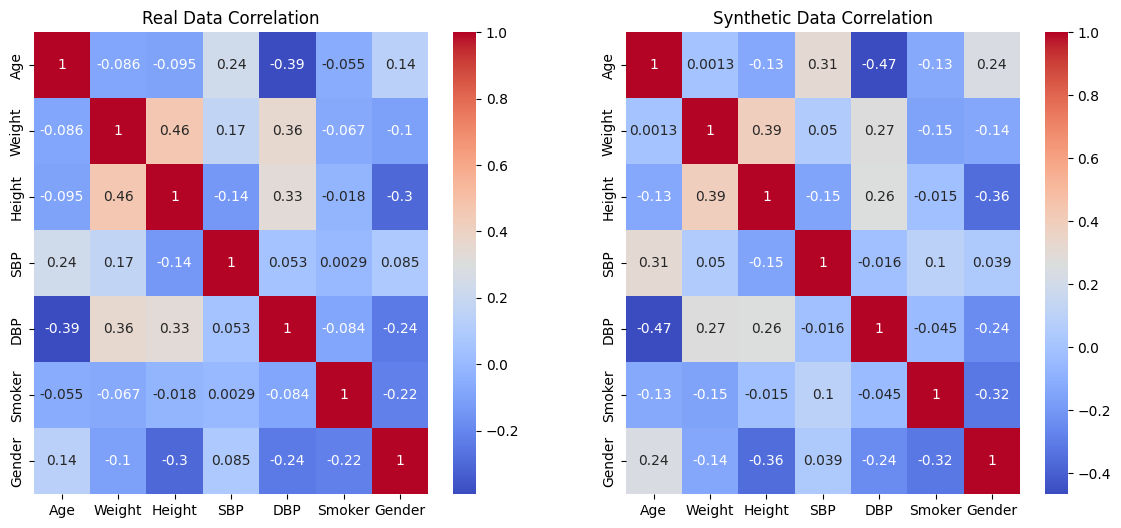

In [37]:
def correlation_heatmap():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(df.drop(columns=["Vascular event"]).corr(), ax=axes[0], cmap="coolwarm", annot=True)
    axes[0].set_title("Real Data Correlation")
    sns.heatmap(synthetic_crfs.drop(columns=["Vascular event"]).corr(), ax=axes[1], cmap="coolwarm", annot=True)
    axes[1].set_title("Synthetic Data Correlation")
    plt.show()

correlation_heatmap()

In [38]:
def stat_distance_metric():
    for column in df.columns:
        if column != 'Vascular event':
            wd = wasserstein_distance(df[column], synthetic_crfs[column])
            ks_stat, ks_p = ks_2samp(df[column], synthetic_crfs[column])
            print(f"Feature: {column}")
            print(f"  Wasserstein Distance: {wd:.4f}")
            print(f"  KS Test p-value: {ks_p:.4f}")
            print("-" * 30)

stat_distance_metric()

Feature: Age
  Wasserstein Distance: 0.9749
  KS Test p-value: 0.0170
------------------------------
Feature: Weight
  Wasserstein Distance: 0.9014
  KS Test p-value: 0.2645
------------------------------
Feature: Height
  Wasserstein Distance: 1.0016
  KS Test p-value: 0.0013
------------------------------
Feature: SBP
  Wasserstein Distance: 3.3922
  KS Test p-value: 0.0016
------------------------------
Feature: DBP
  Wasserstein Distance: 1.3547
  KS Test p-value: 0.0376
------------------------------
Feature: Smoker
  Wasserstein Distance: 0.1359
  KS Test p-value: 0.0000
------------------------------
Feature: Gender
  Wasserstein Distance: 0.0033
  KS Test p-value: 1.0000
------------------------------


In [39]:
target_column = "Vascular event"
X_real = df.drop(columns=[target_column])
X_real = X_real.fillna(X_real.mean())
y_real = df[target_column]
X_syn = synthetic_crfs.drop(columns=[target_column])
X_syn = X_syn.fillna(X_syn.mean())
y_syn = synthetic_crfs[target_column]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred_syn = clf.predict(X_syn)
real_to_syn_acc = accuracy_score(y_syn, pred_syn)

In [41]:
X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(
    X_syn, y_syn, test_size=0.2, random_state=42)
clf_syn = RandomForestClassifier()
clf_syn.fit(X_train_syn, y_train_syn)
pred_real = clf_syn.predict(X_real)
syn_to_real_acc = accuracy_score(y_real, pred_real)

print(f"Train on Real → Test on Synthetic Accuracy: {real_to_syn_acc:.4f}")
print(f"Train on Synthetic → Test on Real Accuracy: {syn_to_real_acc:.4f}")

Train on Real → Test on Synthetic Accuracy: 0.5900
Train on Synthetic → Test on Real Accuracy: 0.7188


In [42]:
print(f"Train on Real → Test on Synthetic Classification Report:\n{classification_report(y_syn, pred_syn)}")
print(f"Train on Synthetic → Test on Real Classification Report:\n{classification_report(y_real, pred_real)}")

Train on Real → Test on Synthetic Classification Report:
                       precision    recall  f1-score   support

myocardial infarction       0.51      0.38      0.43       257
                 none       0.50      0.65      0.56       306
               stroke       0.65      0.56      0.60       244
              syncope       0.77      0.82      0.80       193

             accuracy                           0.59      1000
            macro avg       0.61      0.60      0.60      1000
         weighted avg       0.59      0.59      0.59      1000

Train on Synthetic → Test on Real Classification Report:
                       precision    recall  f1-score   support

myocardial infarction       0.58      0.54      0.56       104
                 none       0.52      0.56      0.54       104
               stroke       0.86      0.94      0.90       104
              syncope       0.93      0.84      0.88       104

             accuracy                           0.72       416

In [43]:
svm_real = SVC()
svm_real.fit(X_train, y_train)
svm_real_pred = svm_real.predict(X_syn)
svm_real_to_syn_acc = accuracy_score(y_syn, svm_real_pred)
svm_syn = SVC()
svm_syn.fit(X_train_syn, y_train_syn)
svm_syn_pred = svm_syn.predict(X_real)
svm_syn_to_real_acc = accuracy_score(y_real, svm_syn_pred)

print(f"Train on Real → Test on Synthetic Accuracy: {svm_real_to_syn_acc:.4f}")
print(f"Train on Synthetic → Test on Real Accuracy: {svm_syn_to_real_acc:.4f}")

Train on Real → Test on Synthetic Accuracy: 0.5280
Train on Synthetic → Test on Real Accuracy: 0.5312


In [44]:
print(f"Train on Real → Test on Synthetic Classification Report:\n{classification_report(y_syn, pred_syn)}")
print(f"Train on Synthetic → Test on Real Classification Report:\n{classification_report(y_real, pred_real)}")

Train on Real → Test on Synthetic Classification Report:
                       precision    recall  f1-score   support

myocardial infarction       0.51      0.38      0.43       257
                 none       0.50      0.65      0.56       306
               stroke       0.65      0.56      0.60       244
              syncope       0.77      0.82      0.80       193

             accuracy                           0.59      1000
            macro avg       0.61      0.60      0.60      1000
         weighted avg       0.59      0.59      0.59      1000

Train on Synthetic → Test on Real Classification Report:
                       precision    recall  f1-score   support

myocardial infarction       0.58      0.54      0.56       104
                 none       0.52      0.56      0.54       104
               stroke       0.86      0.94      0.90       104
              syncope       0.93      0.84      0.88       104

             accuracy                           0.72       416

In [45]:
knn_real = KNeighborsClassifier()
knn_real.fit(X_train, y_train)
knn_real_pred = knn_real.predict(X_syn)
knn_real_to_syn_acc = accuracy_score(y_syn, knn_real_pred)

knn_syn = KNeighborsClassifier()
knn_syn.fit(X_train_syn, y_train_syn)
knn_syn_pred = knn_syn.predict(X_real)
knn_syn_to_real_acc = accuracy_score(y_real, knn_syn_pred)

print(f"Train on Real → Test on Synthetic (KNN) Accuracy: {knn_real_to_syn_acc:.4f}")
print(f"Train on Synthetic → Test on Real (KNN) Accuracy: {knn_syn_to_real_acc:.4f}")

Train on Real → Test on Synthetic (KNN) Accuracy: 0.5650
Train on Synthetic → Test on Real (KNN) Accuracy: 0.6851


In [46]:
print(f"Train on Real → Test on Synthetic Classification Report:\n{classification_report(y_syn, pred_syn)}")
print(f"Train on Synthetic → Test on Real Classification Report:\n{classification_report(y_real, pred_real)}")

Train on Real → Test on Synthetic Classification Report:
                       precision    recall  f1-score   support

myocardial infarction       0.51      0.38      0.43       257
                 none       0.50      0.65      0.56       306
               stroke       0.65      0.56      0.60       244
              syncope       0.77      0.82      0.80       193

             accuracy                           0.59      1000
            macro avg       0.61      0.60      0.60      1000
         weighted avg       0.59      0.59      0.59      1000

Train on Synthetic → Test on Real Classification Report:
                       precision    recall  f1-score   support

myocardial infarction       0.58      0.54      0.56       104
                 none       0.52      0.56      0.54       104
               stroke       0.86      0.94      0.90       104
              syncope       0.93      0.84      0.88       104

             accuracy                           0.72       416

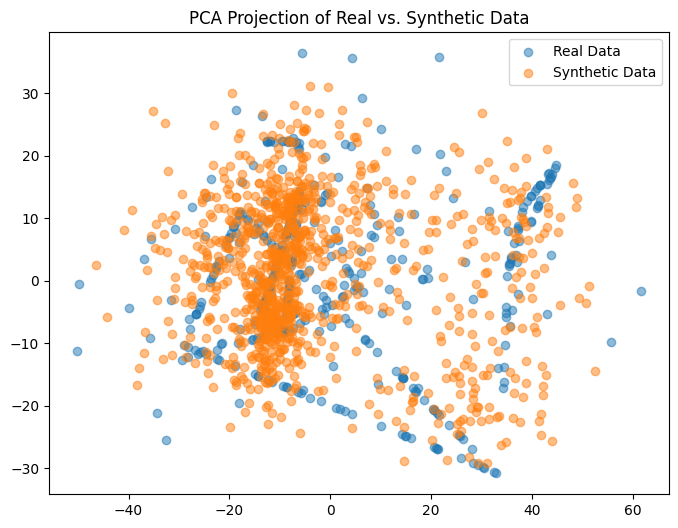

In [47]:
pca = PCA(n_components=2)
real_pca = pca.fit_transform(X_real)
synthetic_pca = pca.transform(X_syn)
plt.figure(figsize=(8, 6))
plt.scatter(real_pca[:, 0], real_pca[:, 1], label="Real Data", alpha=0.5)
plt.scatter(synthetic_pca[:, 0], synthetic_pca[:, 1],
            label="Synthetic Data", alpha=0.5)
plt.legend()
plt.title("PCA Projection of Real vs. Synthetic Data")
plt.show()


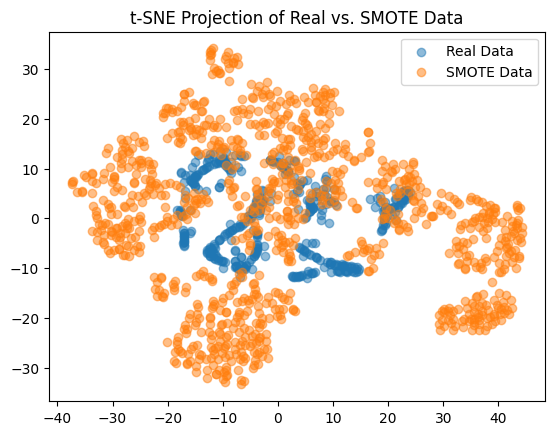

In [48]:
# t-SNE for deeper structure validation
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_real_tsne = tsne.fit_transform(X_real)
X_smote_tsne = tsne.fit_transform(X_syn)

plt.scatter(X_real_tsne[:,0], X_real_tsne[:,1], label="Real Data", alpha=0.5)
plt.scatter(X_smote_tsne[:,0], X_smote_tsne[:,1], label="SMOTE Data", alpha=0.5)
plt.legend()
plt.title("t-SNE Projection of Real vs. SMOTE Data")
plt.show()